In [40]:
# === Imports ===
import sys
import numpy as np
import pandas as pd
import importlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [41]:
# === Load Custom Modules ===
def load_modules():
    sys.path.append('../Python_scripts')  # Adjust if your modules are elsewhere

    global amp, pca_pack, preprocessing, emp_bayes, hierarchical, pipeline
    amp = importlib.import_module("amp")
    pca_pack = importlib.import_module("pca_pack")
    preprocessing = importlib.import_module("preprocessing")
    emp_bayes = importlib.import_module("emp_bayes")
    hierarchical = importlib.import_module("hierarchical_clustering_modalities")
    pipeline = importlib.import_module("complete_pipeline")

    importlib.reload(amp)
    importlib.reload(pca_pack)
    importlib.reload(preprocessing)
    importlib.reload(emp_bayes)
    importlib.reload(hierarchical)
    importlib.reload(pipeline)

    global ebamp_multimodal, MultiModalityPCA, MultiModalityPCADiagnostics
    global ClusterEmpiricalBayes, ModalityClusterer
    global MultimodalPCAPipeline, MultimodalPCAPipelineClustering

    ebamp_multimodal = amp.ebamp_multimodal
    MultiModalityPCA = pca_pack.MultiModalityPCA
    MultiModalityPCADiagnostics = preprocessing.MultiModalityPCADiagnostics
    ClusterEmpiricalBayes = emp_bayes.ClusterEmpiricalBayes
    ModalityClusterer = hierarchical.ModalityClusterer
    MultimodalPCAPipeline = pipeline.MultimodalPCAPipelineSimulation
    MultimodalPCAPipelineClustering = pipeline.MultimodalPCAPipelineClusteringSimulation

In [42]:
# === Utility Functions ===
def generate_rademacher(shape):
    return np.random.choice([-1, 1], size=shape)

def reconstruction_error(U_est, U_true):
    P_est = U_est @ U_est.T
    P_true = U_true @ U_true.T
    return np.linalg.norm(P_est - P_true, 'fro')**2 / (U_true.shape[0]**2)

In [43]:
def run_amp_comparison_experiment(n, p_list, r_list, num_trials, amp_iters, sigma=0.1, compare=False):
    pred_err_clustered, pred_err_same, pred_err_distinct = [], [], []
    errors_clustered = {i: [] for i in range(3)}
    errors_same = {i: [] for i in range(3)}
    errors_distinct = {i: [] for i in range(3)}
    pred_err_clustered_linear, pred_err_same_linear, pred_err_distinct_linear = [], [], []

    for trial in range(num_trials):
        print(f"\n=== Current trial for n = {n}, trial = {trial+1} ===", flush=True)

        # === Simulate data ===
        U1 = generate_rademacher((n, r_list[0]))
        U2 = np.hstack([U1[:, :r_list[0]], generate_rademacher((n, r_list[1] - r_list[0]))])
        U3 = generate_rademacher((n, r_list[2]))
        U_true = [U1, U2, U3]

        beta = generate_rademacher(sum(r_list))

        V1 = generate_rademacher((p_list[0], r_list[0]))
        V2 = generate_rademacher((p_list[1], r_list[1]))
        V3 = generate_rademacher((p_list[2], r_list[2]))

        D1 = np.diag([5 * (i+1) for i in range(r_list[0])])
        D2 = np.diag([5 * (i+1) for i in range(r_list[1])])
        D3 = np.diag([5 * (i+1) for i in range(r_list[2])])

        Z1 = np.random.randn(n, p_list[0]) / np.sqrt(n)
        Z2 = np.random.randn(n, p_list[1]) / np.sqrt(n)
        Z3 = np.random.randn(n, p_list[2]) / np.sqrt(n)

        X1 = (1/n) * U1 @ D1 @ V1.T + Z1
        X2 = (1/n) * U2 @ D2 @ V2.T + Z2
        X3 = (1/n) * U3 @ D3 @ V3.T + Z3
        X_list = [X1, X2, X3]
        K_list = r_list

        U_concat = np.hstack(U_true)
        noise = sigma * np.random.randn(n)
        y_train = U_concat @ beta + noise

        # === Test Data ===
        n_test = n // 10
        U_test_1 = generate_rademacher((n_test, r_list[0]))
        U_test_2 = np.hstack([U_test_1[:, :r_list[0]], generate_rademacher((n_test, r_list[1] - r_list[0]))])
        U_test_3 = generate_rademacher((n_test, r_list[2]))
        U_test = [U_test_1, U_test_2, U_test_3]
        Zt = [np.random.randn(n_test, p) / np.sqrt(n) for p in p_list]
        Xt = [(1/n) * U_test[i] @ D @ V.T + Zt[i] for i, (D, V) in enumerate(zip([D1, D2, D3], [V1, V2, V3]))]
        X_test_list = Xt
        y_test = np.hstack(U_test) @ beta + sigma * np.random.randn(n_test)

        # === Clustered ===
        pipe_cluster = MultimodalPCAPipelineClustering()
        pipe_cluster.y_train = y_train
        pipe_cluster.relation = "non-linear"
        U_cluster = pipe_cluster.denoise_amp(X_list, K_list, compute_clusters=True, num_clusters=2, amp_iters=amp_iters)["U_denoised"]
        _, y_pred_cluster = pipeline.predict_from_test_data(X_test_list, pipe_cluster.amp_results, n, relation="non-linear")

        if compare:
            pipe_cluster.relation = "linear"
            pipe_cluster.denoise_amp(X_list, K_list, compute_clusters=True, num_clusters=2, amp_iters=amp_iters)
            _, y_pred_cluster_lin = pipeline.predict_from_test_data(X_test_list, pipe_cluster.amp_results, n, relation="linear")
            pred_err_clustered_linear.append(np.mean((y_test - y_pred_cluster_lin) ** 2))

        # === Same Cluster ===
        pipe_same = MultimodalPCAPipeline()
        pipe_same.y_train = y_train
        pipe_same.relation = "non-linear"
        U_same = pipe_same.denoise_amp(X_list, K_list, cluster_labels_U=np.array([0, 0, 0]), amp_iters=amp_iters)["U_denoised"]
        _, y_pred_same = pipeline.predict_from_test_data(X_test_list, pipe_same.amp_results, n, relation="non-linear")

        if compare:
            pipe_same.relation = "linear"
            pipe_same.denoise_amp(X_list, K_list, cluster_labels_U=np.array([0, 0, 0]), amp_iters=amp_iters)
            _, y_pred_same_lin = pipeline.predict_from_test_data(X_test_list, pipe_same.amp_results, n, relation="linear")
            pred_err_same_linear.append(np.mean((y_test - y_pred_same_lin) ** 2))

        # === Distinct Clusters ===
        pipe_distinct = MultimodalPCAPipeline()
        pipe_distinct.y_train = y_train
        pipe_distinct.relation = "non-linear"
        U_distinct = pipe_distinct.denoise_amp(X_list, K_list, cluster_labels_U=np.array([0, 1, 2]), amp_iters=amp_iters)["U_denoised"]
        _, y_pred_distinct = pipeline.predict_from_test_data(X_test_list, pipe_distinct.amp_results, n, relation="non-linear")

        if compare:
            pipe_distinct.relation = "linear"
            pipe_distinct.denoise_amp(X_list, K_list, cluster_labels_U=np.array([0, 1, 2]), amp_iters=amp_iters)
            _, y_pred_distinct_lin = pipeline.predict_from_test_data(X_test_list, pipe_distinct.amp_results, n, relation="linear")
            pred_err_distinct_linear.append(np.mean((y_test - y_pred_distinct_lin) ** 2))

        # === Reconstruction Errors ===
        for i in range(3):
            errors_clustered[i].append(reconstruction_error(U_cluster[i][:, :, -1], U_true[i]))
            errors_same[i].append(reconstruction_error(U_same[i][:, :, -1], U_true[i]))
            errors_distinct[i].append(reconstruction_error(U_distinct[i][:, :, -1], U_true[i]))

        pred_err_clustered.append(np.mean((y_test - y_pred_cluster) ** 2))
        pred_err_same.append(np.mean((y_test - y_pred_same) ** 2))
        pred_err_distinct.append(np.mean((y_test - y_pred_distinct) ** 2))

    return {
        "n": n,
        "clustered": [np.mean(errors_clustered[i]) for i in range(3)],
        "same_cluster": [np.mean(errors_same[i]) for i in range(3)],
        "distinct_clusters": [np.mean(errors_distinct[i]) for i in range(3)],
        "pred_clustered": np.mean(pred_err_clustered),
        "pred_same_cluster": np.mean(pred_err_same),
        "pred_distinct_clusters": np.mean(pred_err_distinct),
        "pred_clustered_linear": np.mean(pred_err_clustered_linear) if compare else None,
        "pred_same_cluster_linear": np.mean(pred_err_same_linear) if compare else None,
        "pred_distinct_clusters_linear": np.mean(pred_err_distinct_linear) if compare else None,
    }

In [44]:
# === Run the Experiment ===
load_modules()

n = 1000
p_list = [500, 750, 500]
r_list = [2, 4, 6]
num_trials = 5
amp_iters = 12
sigma = 0.1

# Enable comparison between linear and non-linear predictions
results = run_amp_comparison_experiment(
    n=n,
    p_list=p_list,
    r_list=r_list,
    num_trials=num_trials,
    amp_iters=amp_iters,
    sigma=sigma,
    compare=True
)


=== Current trial for n = 1000, trial = 1 ===
[1 1 2]
[Nonlinear] Ep 0, loss 11.5852
[Nonlinear] Ep 100, loss 7.6128
[Nonlinear] Ep 200, loss 5.8158
[Nonlinear] Ep 300, loss 5.7694
[Nonlinear] Ep 400, loss 5.7620
[Nonlinear] Ep 500, loss 5.7574
[Nonlinear] Ep 600, loss 5.7541
[Nonlinear] Ep 700, loss 5.7505
[Nonlinear] Ep 800, loss 5.7479
[Nonlinear] Ep 900, loss 5.7460
[Nonlinear] Ep 1000, loss 5.7439
[Nonlinear] Ep 1100, loss 5.7420
[Nonlinear] Ep 1200, loss 5.7399
[Nonlinear] Ep 1300, loss 5.7377
[Nonlinear] Ep 1400, loss 5.7357
[Nonlinear] Ep 1500, loss 5.7338
[Nonlinear] Ep 1600, loss 5.7317
[Nonlinear] Ep 1700, loss 5.7294
[Nonlinear] Ep 1800, loss 5.7267
[Nonlinear] Ep 1900, loss 5.7237
[1 1 2]
[Nonlinear] Ep 0, loss 11.4023
[Nonlinear] Ep 100, loss 11.3303
[Nonlinear] Ep 200, loss 11.3303
[Nonlinear] Ep 300, loss 11.3303
[Nonlinear] Ep 400, loss 11.3303
[Nonlinear] Ep 500, loss 11.3303
[Nonlinear] Ep 600, loss 11.3303
[Nonlinear] Ep 700, loss 11.3303
[Nonlinear] Ep 800, loss 1

In [45]:
# === Show Results ===
print("=== Summary of Results ===")
print(f"Prediction Error (Nonlinear - Clustered): {results['pred_clustered']:.4f}")
print(f"Prediction Error (Nonlinear - Same Cluster): {results['pred_same_cluster']:.4f}")
print(f"Prediction Error (Nonlinear - Distinct Clusters): {results['pred_distinct_clusters']:.4f}")

# Show linear results if present
if "pred_clustered_linear" in results:
    print()
    print(f"Prediction Error (Linear - Clustered): {results['pred_clustered_linear']:.4f}")
    print(f"Prediction Error (Linear - Same Cluster): {results['pred_same_cluster_linear']:.4f}")
    print(f"Prediction Error (Linear - Distinct Clusters): {results['pred_distinct_clusters_linear']:.4f}")

print()
print("Reconstruction Errors by Modality:")
for i, modality in enumerate(["Modality 1", "Modality 2", "Modality 3"]):
    print(f"{modality} - Clustered: {results['clustered'][i]:.4f}, "
          f"Same: {results['same_cluster'][i]:.4f}, "
          f"Distinct: {results['distinct_clusters'][i]:.4f}")

=== Summary of Results ===
Prediction Error (Nonlinear - Clustered): 6.4180
Prediction Error (Nonlinear - Same Cluster): 12.5603
Prediction Error (Nonlinear - Distinct Clusters): 6.0635

Prediction Error (Linear - Clustered): 6.0690
Prediction Error (Linear - Same Cluster): 12.5603
Prediction Error (Linear - Distinct Clusters): 6.0481

Reconstruction Errors by Modality:
Modality 1 - Clustered: 0.5221, Same: 2.0022, Distinct: 0.0063
Modality 2 - Clustered: 0.9587, Same: 4.0116, Distinct: 0.0615
Modality 3 - Clustered: 6.1359, Same: 6.0377, Distinct: 6.0357


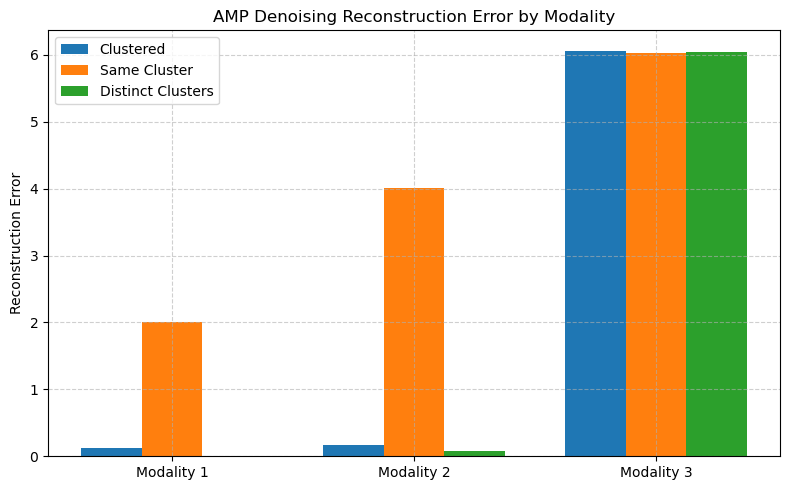

In [33]:
# === Plot Reconstruction Errors ===
modality_labels = ["Modality 1", "Modality 2", "Modality 3"]
x = np.arange(3)
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, results["clustered"], width, label='Clustered')
plt.bar(x, results["same_cluster"], width, label='Same Cluster')
plt.bar(x + width, results["distinct_clusters"], width, label='Distinct Clusters')
plt.xticks(x, modality_labels)
plt.ylabel("Reconstruction Error")
plt.title("AMP Denoising Reconstruction Error by Modality")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()